In [1]:
%load_ext autoreload
%autoreload 2

import os

import copy

import numpy as np
import matplotlib.pyplot as plt

from astropy import wcs
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.table import Table, Column, hstack

from mrf.display import display_single, SEG_CMAP
from IPython.display import clear_output

plt.rcParams['text.usetex'] = True

## Here we use the LSBG sample from Greco et al. 2018 http://adsabs.harvard.edu/abs/2018ApJ...857..104G. 

In [2]:
lsbg_cat = Table.read('LSB-Greco2018.fits', format='fits')

In [3]:
flag = (lsbg_cat['imag'] < 21) & (lsbg_cat['imag'] > 19) & (
    lsbg_cat['iSB'] > 23) & (lsbg_cat['n'] < 1.5) & (lsbg_cat['n'] > 0.8) & (lsbg_cat['imag'] < 21) & (
        lsbg_cat['Reff'] < 7) & (lsbg_cat['Ell'] < 0.25) & (abs(lsbg_cat['DEJ2000']) < 3)

In [4]:
lsbg_cat[flag].write('LSB-candidate.fits', overwrite=True)
lsbg_cat = lsbg_cat[flag]

## We download DECaLS images and degrade using a Sersic kernel

In [142]:
from mrf.download import download_decals_cutout
# We make a Sersic kernel
from astropy.modeling.functional_models import Sersic2D, Gaussian2D
from astropy.convolution import convolve_fft
from mrf.celestial import Celestial

In [149]:
for obj in lsbg_cat[32:50]:
    ra, dec = obj['RAJ2000'], obj['DEJ2000']
    cutout_size = 3000 # pix for DECaLS
    download_decals_cutout(ra, dec, cutout_size, 'r', pixel_unit=True, 
                           output_dir='DECaLS_cutout/', output_name='DECaLS_{:03d}'.format(obj['Seq']))
    download_decals_cutout(ra, dec, cutout_size, 'g', pixel_unit=True, 
                           output_dir='DECaLS_cutout/', output_name='DECaLS_{:03d}'.format(obj['Seq']))
    clear_output()

DECaLS_533_r.fits: 0.00B [00:00, ?B/s]


KeyboardInterrupt: 

In [188]:
for obj in lsbg_cat[10:30]:
    for filt in ['g', 'r']:
        hdu = fits.open('./DECaLS_cutout/DECaLS_{0:03d}_{1}.fits'.format(obj['Seq'], filt))
        hires = Celestial(hdu[0].data, header=hdu[0].header)
        hdu.close()

        size = 200
        #m_sersic = Gaussian2D(amplitude=1, x_mean=size, y_mean=size, x_stddev=10, y_stddev=10)
        m_sersic = Sersic2D(r_eff=15, n=0.95, x_0=size, y_0=size)
        y, x = np.mgrid[:(size * 2 + 1), :(size * 2 + 1)]
        sersic_kernel = m_sersic(x, y)
        sersic_kernel /= np.sum(sersic_kernel) # normalize
        fakeDF = convolve_fft(hires.image, kernel=sersic_kernel, allow_huge=True)
        hires.image = fakeDF
        hires.resize_image(hires.pixel_scale / 2.5, method='iraf')
        hires.save_to_fits('./DECaLS_cutout/LSBG_{0:03d}_lowres_{1}.fits'.format(obj['Seq'], filt))

In [177]:
np.median(lsbg_cat['n'])

0.89

### Implement `mrf` task by providing directories of input images, along with galaxies you want to retain during `mrf`.

In [304]:
for obj in lsbg_cat[0:30]:
    if obj['Seq'] == 245:
        continue
    else:
        task = MrfTask('LSBG-task-cross-g.yaml')
        img_lowres = './DECaLS_cutout/LSBG_{0:03d}_lowres_{1}.fits'.format(obj['Seq'], 'g')
        img_hires_b = './HSC_cutout/LSBG_{0:03d}_hires_{1}_bin.fits'.format(obj['Seq'], 'g')
        img_hires_r = './HSC_cutout/LSBG_{0:03d}_hires_{1}_bin.fits'.format(obj['Seq'], 'r')
        certain_gal_cat = None
        results = task.run(img_lowres, img_hires_b, img_hires_r, certain_gal_cat, 
                           output_name='LSBG_g_{:03d}'.format(obj['Seq']), verbose=True)
        clear_output()

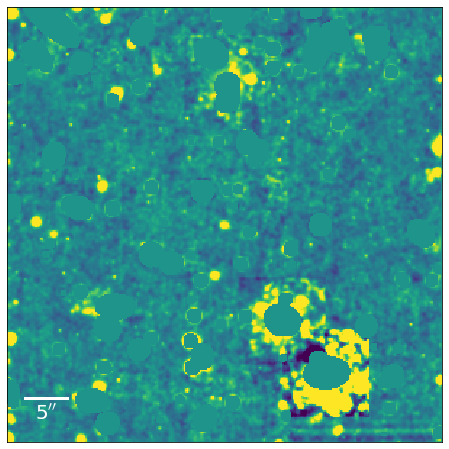

In [198]:
from mrf.utils import adjust_mask
results = adjust_mask(results, gaussian_threshold=0.007, r=4)

## Demo results

In [115]:
from mrf.utils import img_cutout
from mrf.display import display_multiple

In [305]:
for obj in lsbg_cat[0:30]:
    if obj['Seq'] != 245:
        ra, dec = obj['RAJ2000'], obj['DEJ2000']
        size = 600 # pix for DECaLS

        hdu = fits.open('./DECaLS_cutout/LSBG_{0:03d}_lowres_{1}.fits'.format(obj['Seq'], 'g'))
        lowres = img_cutout(hdu[0].data, wcs.WCS(hdu[0].header), 
                            ra, dec, pixel_scale=2.617, size=size, save=False)
        hdu.close()

        hdu = fits.open('./DECaLS_cutout/DECaLS_{0:03d}_{1}.fits'.format(obj['Seq'], 'g'))
        truth = img_cutout(hdu[0].data, wcs.WCS(hdu[0].header), ra, dec, 
                              pixel_scale=0.262, size=size, save=False)
        hdu.close()

        hdu = fits.open('./HSC_cutout/LSBG_{0:03d}_hires_{1}_bin.fits'.format(obj['Seq'], 'g'))
        hires = img_cutout(hdu[0].data, wcs.WCS(hdu[0].header), ra, dec, 
                              pixel_scale=0.336, size=size, save=False)
        hdu.close()

        hdu = fits.open('LSBG_g_{:03d}_final.fits'.format(obj['Seq']))
        final = img_cutout(hdu[0].data, wcs.WCS(hdu[0].header), ra, dec, 
                              pixel_scale=2.617, size=size, save=False)
        hdu.close()

        ### show figure ###
        fig, [ax1, ax2, ax3, ax4] = plt.subplots(1, 4, figsize=(19, 5))
        ax1 = display_single(truth[0].data, ax=ax1, add_text='DECaLS', 
                             pixel_scale=0.262, scale_bar_length=61, scale_bar_y_offset=0.25)
        ax3 = display_single(hires[0].data, ax=ax3, add_text='HSC(Hires)', 
                             pixel_scale=0.168, scale_bar=False)
        display_multiple([lowres[0].data, final[0].data], ax=[ax2, ax4], text=['FakeLowres', 'CrossMRF'], scale_bar=False)

        for ax in [ax1, ax2, ax3, ax4]:   
            ax.axis('off')
        plt.subplots_adjust(wspace=0.03)

        plt.savefig('LSBG_g_{:03d}_crossMRF.png'.format(obj['Seq']), bbox_inches='tight')
        plt.close()

## Make a demo for LSBG-443

In [ ]:
obj = lsbg_cat[20]

In [ ]:
from mrf.task import MrfTask
task = MrfTask('LSBG-task-cross-g.yaml')
img_lowres = './DECaLS_cutout/LSBG_{0:03d}_lowres_{1}.fits'.format(obj['Seq'], 'g')
img_hires_b = './HSC_cutout/LSBG_{0:03d}_hires_{1}_bin.fits'.format(obj['Seq'], 'g')
img_hires_r = './HSC_cutout/LSBG_{0:03d}_hires_{1}_bin.fits'.format(obj['Seq'], 'r')
certain_gal_cat = None
results = task.run(img_lowres, img_hires_b, img_hires_r, certain_gal_cat, 
                   output_name='LSBG_g_{:03d}'.format(obj['Seq']), verbose=True)

In [336]:
ra, dec

(223.97444, 1.27432)

In [314]:
ra, dec = obj['RAJ2000'], obj['DEJ2000']
size = 600 # pix for DECaLS

hdu = fits.open('./DECaLS_cutout/LSBG_{0:03d}_lowres_{1}.fits'.format(obj['Seq'], 'g'))
lowres = img_cutout(hdu[0].data, wcs.WCS(hdu[0].header), 
                    ra, dec, pixel_scale=2.617, size=size, save=False)
hdu.close()

hdu = fits.open('./DECaLS_cutout/DECaLS_{0:03d}_{1}.fits'.format(obj['Seq'], 'g'))
truth = img_cutout(hdu[0].data, wcs.WCS(hdu[0].header), ra, dec, 
                      pixel_scale=0.262, size=size, save=False)
hdu.close()

hdu = fits.open('./HSC_cutout/LSBG_{0:03d}_hires_{1}_bin.fits'.format(obj['Seq'], 'g'))
hires = img_cutout(hdu[0].data, wcs.WCS(hdu[0].header), ra, dec, 
                      pixel_scale=0.336, size=size, save=False)
hdu.close()

hdu = fits.open('LSBG_g_{:03d}_final.fits'.format(obj['Seq']))
final = img_cutout(hdu[0].data, wcs.WCS(hdu[0].header), ra, dec, 
                      pixel_scale=2.617, size=size, save=False)
hdu.close()

### show figure ###
fig, [ax1, ax2, ax3, ax4, ax5] = plt.subplots(1, 5, figsize=(24, 5))
ax2 = display_single(truth[0].data, ax=ax2, add_text='DECaLS', 
                     pixel_scale=0.262, scale_bar_length=61, scale_bar_y_offset=0.25)
ax1 = display_single(hires[0].data, ax=ax1, add_text='HSC(Hires)', 
                     pixel_scale=0.168, scale_bar=False)
ax4 = display_single(results.lowres_model.image, ax=ax4, add_text='Model', 
                     pixel_scale=0.168, scale_bar=False)
display_multiple([lowres[0].data, final[0].data], ax=[ax3, ax5], text=['FakeLowres', 'CrossMRF'], scale_bar=False)

for ax in [ax1, ax2, ax3, ax4, ax5]:   
    ax.axis('off')
plt.subplots_adjust(wspace=0.03)

plt.savefig('LSBG_g_{:03d}_crossMRF.png'.format(obj['Seq']), bbox_inches='tight')
plt.close()

In [329]:
import astropy.units as u
from astropy.coordinates import SkyCoord
from unagi.hsc import Hsc
from unagi.task import hsc_tricolor
pdr2 = Hsc(dr='pdr2', rerun='pdr2_wide')


rgb = hsc_tricolor(SkyCoord(ra, dec, unit='deg'), cutout_size=100 * u.arcsec / 2, 
                   archive=pdr2, save_rgb=True, rgb_stretch=0.35)



# Get table list from /Users/jiaxuanli/Research/Packages/unagi/unagi/data/pdr2_wide/pdr2_wide_tables.fits
# RGB picture will be saved as ./pdr2_wide_223.9744_1.2743_50.00arcsec_gri.jpg
# Retrieving cutout image in filter: g
# Retrieving cutout image in filter: r
# Retrieving cutout image in filter: i


![](./pdr2_wide_223.9744_1.2743_50.00arcsec_gri.jpg)

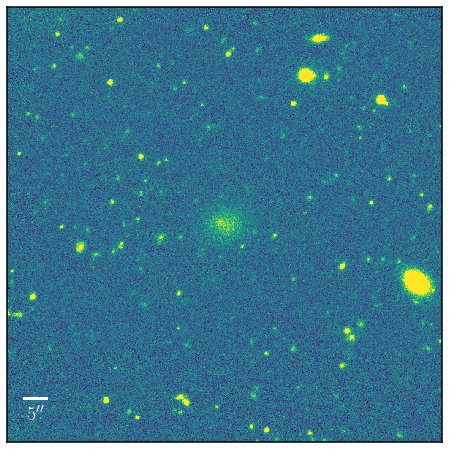

In [335]:
hdu = fits.open('./HSC_cutout/HSC_{0:03d}_{1}.fits'.format(obj['Seq'], 'g'))
dwarf = img_cutout(hdu[1].data, wcs.WCS(hdu[1].header), 
                    ra, dec, pixel_scale=0.168, size=100, save=False)
hdu.close()
display_single(dwarf[0].data);